In [1]:
import scanpy as sc, anndata as ad, numpy as np, pandas as pd
from scipy import sparse
from anndata import AnnData
import warnings
import socket
from matplotlib import pylab
import random
import sys
import yaml
import numbers
import os
import plotly.express as px
import matplotlib.pyplot as plt
import scvelo as scv
import rpy2
import rpy2.robjects as ro
import seaborn as sns

warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
sc.settings.verbosity = 3         # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')
pylab.rcParams['figure.figsize'] = (10, 10)


scanpy==1.8.0 anndata==0.8.0 umap==0.4.6 numpy==1.22.2 scipy==1.6.2 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.13.5 python-igraph==0.9.1 louvain==0.7.0 leidenalg==0.8.3


### Configure paths

In [4]:
outdir = "../data/output"

with open("../data/resources/iPSC_lines_map.yaml", 'r') as f:
    iPSC_lines_map = yaml.load(f, Loader=yaml.FullLoader)["lines"]
colorsmap = dict(zip([i["newName"] for i in iPSC_lines_map.values()],[i["color"] for i in iPSC_lines_map.values()]))


figDir = "./figures"
if not os.path.exists(figDir):
   # Create a new directory because it does not exist
   os.makedirs(figDir)
    
cellcycleReplicate1_path = "../data/assays/CellCycle_replicate1.tsv"
cellcycleReplicate2_path = "../data/assays/CellCycle_replicate2.tsv"
Namesmap = dict(zip([i["oldName"] for i in iPSC_lines_map.values()],[i["newName"] for i in iPSC_lines_map.values()]))


In [5]:
colorsmap['chimeric'] = 'black'

# First let's process cell cycle dataM

In [6]:
cellcycleReplicate1 = pd.read_csv(cellcycleReplicate1_path, sep="\t", usecols=[1,2,5,6,7], names=["iPSCline","day","G1","S","G2"], header=0)
cellcycleReplicate1["prol"] = (cellcycleReplicate1["S"]+cellcycleReplicate1["G2"] )/ (cellcycleReplicate1["S"]+cellcycleReplicate1["G2"]+cellcycleReplicate1["G1"])
cellcycleReplicate1.replace({"CTL01A":"CTL01"}, inplace=True)
cellcycleReplicate1

,iPSCline,day,G1,S,G2,prol
0,CTL01,-2,26.1,45.7,28.30,0.739261
1,CTL01,0,24.4,56.2,16.30,0.748194
2,CTL01,5,43.3,38.6,17.20,0.563068
3,CTL01,12,62.2,26.9,13.60,0.394352
4,CTL02A,-2,22.3,49.6,27.30,0.775202
5,CTL02A,0,14.9,60.4,27.60,0.855199
6,CTL02A,5,38.1,44.4,15.60,0.611621
7,CTL02A,12,56.2,32.6,13.20,0.449020
8,CTL04E,-2,25.6,42.8,32.30,0.745780
9,CTL04E,0,21.2,56.3,23.60,0.790307


In [7]:
cellcycleReplicate2 = pd.read_csv(cellcycleReplicate2_path, sep="\t", names=["iPSCline","day","G0/G1","S","G2/M","method"], header=0)
cellcycleReplicate2["prol"] = (cellcycleReplicate2["S"]+cellcycleReplicate2["G2/M"] )/ (cellcycleReplicate2["S"]+cellcycleReplicate2["G2/M"]+cellcycleReplicate2["G0/G1"])
cellcycleReplicate2.replace({"CTL01A":"CTL01"}, inplace=True)
cellcycleReplicate2 = cellcycleReplicate2[cellcycleReplicate2.method == "auto"]
cellcycleReplicate2 = cellcycleReplicate2.replace({'CHIMERIC':'chimeric'})
cellcycleReplicate2

,iPSCline,day,G0/G1,S,G2/M,method,prol
0,CTL01,-2,26.93,46.62,26.44,auto,0.730673
1,CTL02A,-2,31.51,54.02,14.48,auto,0.684932
2,CTL04E,-2,41.81,43.38,14.81,auto,0.581900
3,CTL08A,-2,33.62,59.15,7.32,auto,0.664102
4,CTL01,0,50.58,49.42,0.00,auto,0.494200
5,CTL02A,0,50.28,49.72,0.00,auto,0.497200
6,CTL04E,0,35.67,63.13,1.20,auto,0.643300
7,CTL08A,0,37.51,62.49,0.00,auto,0.624900
8,chimeric,0,38.50,59.68,1.81,auto,0.614961
9,CTL01,5,63.05,29.05,7.90,auto,0.369500


# Scale plots length for main figs

In [8]:
# scale plot length according to timepoints

lengthDict = {3:cellcycleReplicate1.day.max(),
              4:cellcycleReplicate2.day.max()}


maxLength = 12
MaxTimepoints = np.array(list(lengthDict.values())).max()

In [9]:
lengthDict = {k:(v/MaxTimepoints*maxLength) for k,v in lengthDict.items()}

# replicate 3 Polts

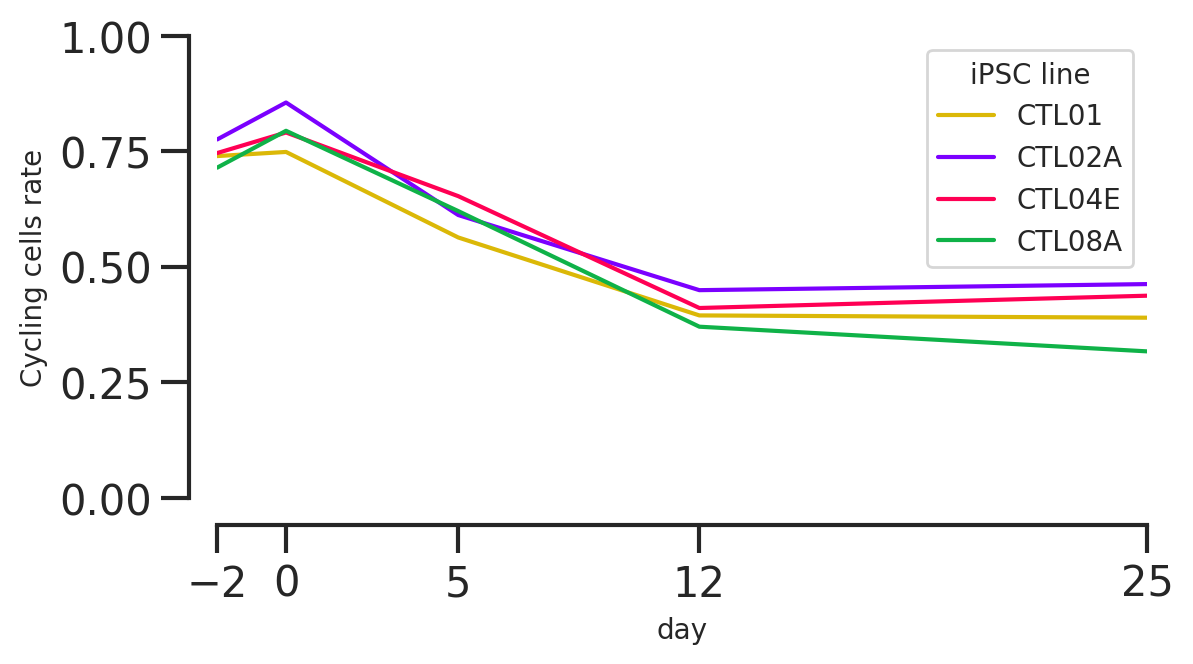

In [10]:
replicate=3
cycling = cellcycleReplicate1
ylimsAbundance = [0, .5]
####################################################
plt.rcdefaults()

sns.set_style("ticks", {'axes.grid' : False})

fig, axes = plt.subplots(1,1, figsize=(lengthDict[replicate],3))



#axes.xaxis.grid(True) # Show the vertical gridlines
#axes[1].xaxis.grid(True) # Show the vertical gridlines

sns.lineplot(data=cycling, x="day", y="prol", ax = axes, hue='iPSCline',palette=colorsmap)

#sns.catplot(data=cellcycleReplicate1,  hue = "iPSCline",x="day", y="prol", kind="point", palette=colorsmap,ax=axes)


axes.set_ylabel("Cycling cells rate", visible=True)
axes.legend(title='iPSC line')
axes.yaxis.tick_left()
axes.spines[['right', 'top']].set_visible(False)
axes.spines['left'].set_linewidth(1.5)
axes.spines['bottom'].set_linewidth(1.5)

axes.tick_params(axis='y', which='major', labelsize=15, width=1.5, length=10)
axes.tick_params(axis='x', which='major', labelsize=15, width=1.5, length=10)
axes.set_ylim([0, 1])
axes.set_yticks([0,.25,.5,.75,1])
axes.set_xlim([cycling.day.min(), cycling.day.max()])





sns.despine(ax=axes, top=True, right=True, left=False, bottom=False, offset=10, trim=False)
axes.yaxis.set_label_position("left")
axes.set_xticks(cellcycleReplicate1.day.sort_values().unique())


fig.savefig(figDir+"/replicate3_cycle.svg")


# replicate 4 plots

In [11]:
cellcycleReplicate2

,iPSCline,day,G0/G1,S,G2/M,method,prol
0,CTL01,-2,26.93,46.62,26.44,auto,0.730673
1,CTL02A,-2,31.51,54.02,14.48,auto,0.684932
2,CTL04E,-2,41.81,43.38,14.81,auto,0.581900
3,CTL08A,-2,33.62,59.15,7.32,auto,0.664102
4,CTL01,0,50.58,49.42,0.00,auto,0.494200
5,CTL02A,0,50.28,49.72,0.00,auto,0.497200
6,CTL04E,0,35.67,63.13,1.20,auto,0.643300
7,CTL08A,0,37.51,62.49,0.00,auto,0.624900
8,chimeric,0,38.50,59.68,1.81,auto,0.614961
9,CTL01,5,63.05,29.05,7.90,auto,0.369500


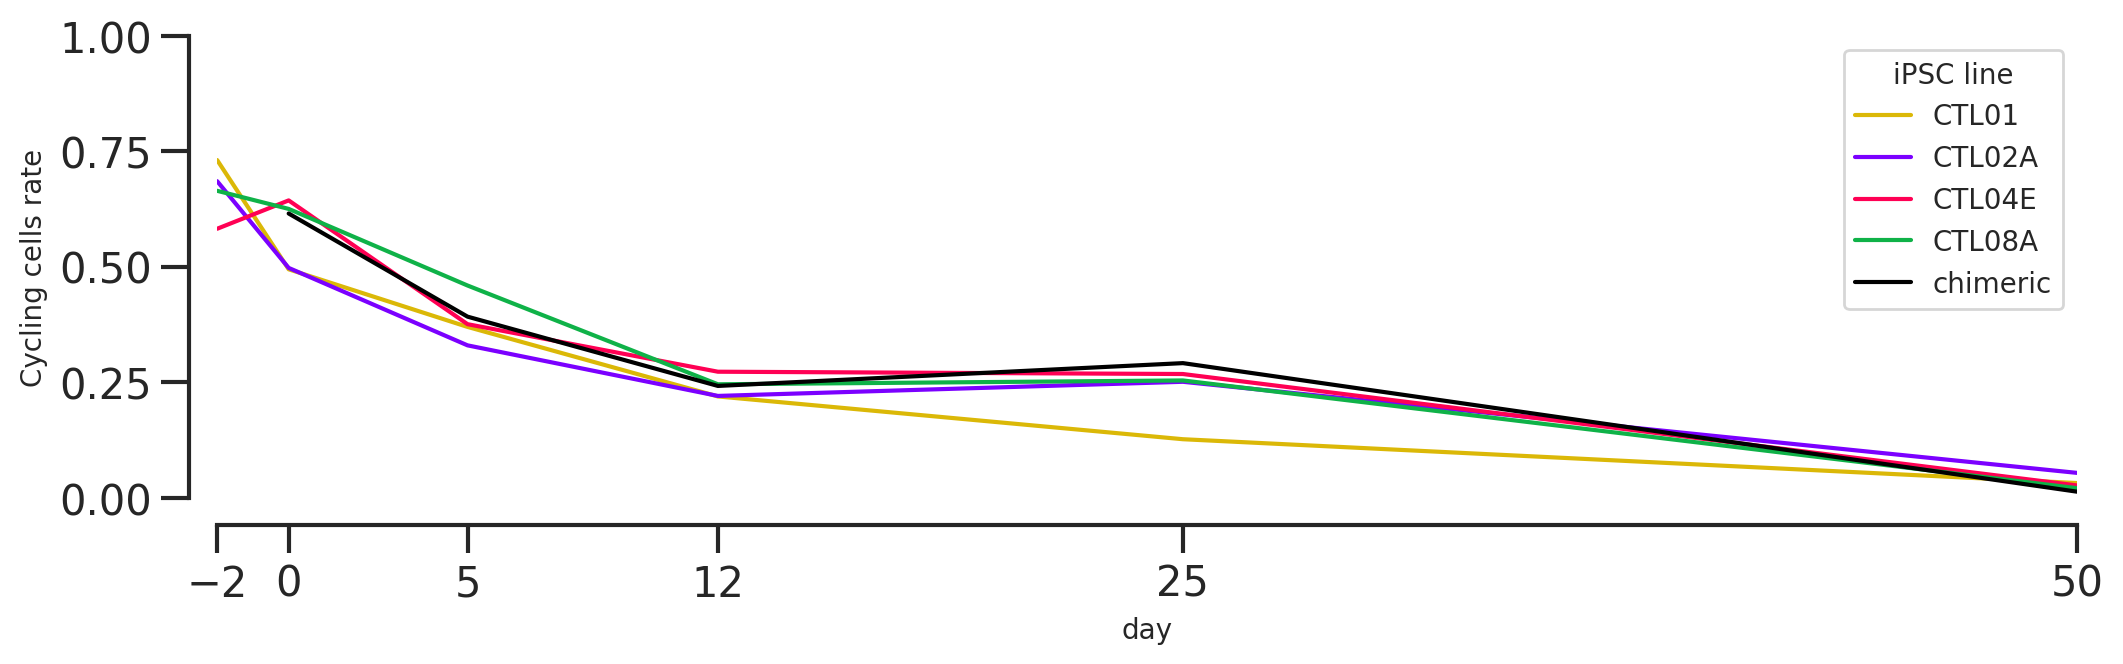

In [12]:
replicate=4
cycling = cellcycleReplicate2
ylimsAbundance = [0, .5]
####################################################
plt.rcdefaults()

sns.set_style("ticks", {'axes.grid' : False})

fig, axes = plt.subplots(1,1, figsize=(lengthDict[replicate],3))



#axes.xaxis.grid(True) # Show the vertical gridlines
#axes[1].xaxis.grid(True) # Show the vertical gridlines

sns.lineplot(data=cycling, x="day", y="prol", ax = axes, hue='iPSCline',palette=colorsmap)

#sns.catplot(data=cellcycleReplicate1,  hue = "iPSCline",x="day", y="prol", kind="point", palette=colorsmap,ax=axes)


axes.set_ylabel("Cycling cells rate", visible=True)
axes.legend(title='iPSC line')
axes.yaxis.tick_left()
axes.spines[['right', 'top']].set_visible(False)
axes.spines['left'].set_linewidth(1.5)
axes.spines['bottom'].set_linewidth(1.5)

axes.tick_params(axis='y', which='major', labelsize=15, width=1.5, length=10)
axes.tick_params(axis='x', which='major', labelsize=15, width=1.5, length=10)
axes.set_ylim([0, 1])
axes.set_yticks([0,.25,.5,.75,1])
axes.set_xlim([cycling.day.min(), cycling.day.max()])





sns.despine(ax=axes, top=True, right=True, left=False, bottom=False, offset=10, trim=False)
axes.yaxis.set_label_position("left")
axes.set_xticks(cellcycleReplicate2.day.sort_values().unique())


fig.savefig(figDir+"/replicate4_cycle.svg")
